### Inference notebook:
- https://www.kaggle.com/code/ravaghi/isic-2024-swin-transformer-inference

# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import warnings
import h5py
import torch
import random
import timm
import cv2
import io
import os
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    train_metadata_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
    test_metadata_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'
    train_img_path = '/kaggle/input/isic-2024-challenge/train-image.hdf5'
    test_img_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5'
    sample_sub_path = '/kaggle/input/isic-2024-challenge/sample_submission.csv'
    checkpoint_path = '/kaggle/working/checkpoints'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image_size = 224
    max_epochs = 50
    learning_rate = 1e-5
    weight_decay = 1e-6
    min_lr = 1e-10
    t_max = 1000
    train_batch_size = 32
    val_batch_size = 64
    n_folds = 5
    seed = 35555
    model_name = "swin_base_patch4_window7_224"
    es_patience = 10

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG.seed)

# Loading and splitting the datasets

In [4]:
train_metadata = pd.read_csv(CFG.train_metadata_path)

positives = train_metadata[train_metadata.target == 1]
negatives = train_metadata[train_metadata.target == 0]
train_metadata = pd.concat([positives, negatives.sample(n=20 * len(positives), random_state=CFG.seed)])
train_metadata = train_metadata.sample(frac=1, random_state=CFG.seed).reset_index(drop=True)

In [5]:
sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = sgkf.split(train_metadata, train_metadata.target, groups=train_metadata.patient_id)
for i, (_, val_index) in enumerate(split):
    train_metadata.loc[val_index, 'fold'] = i

In [6]:
train_metadata2 = pd.read_csv(CFG.train_metadata_path)

sgkf = StratifiedGroupKFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True)
split = sgkf.split(train_metadata2, train_metadata2.target, groups=train_metadata2.patient_id)
for i, (_, val_index) in enumerate(split):
    train_metadata2.loc[val_index, 'fold'] = i

In [7]:
CFG.t_max = train_metadata.shape[0] * (CFG.n_folds-1) * CFG.max_epochs // CFG.train_batch_size // CFG.n_folds

# Creating a custom image dataset

In [8]:
class ISICDataset(Dataset):
    def __init__(self, data_path, metadata, transform=None):
        self.data = h5py.File(data_path, 'r')
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = self.metadata.iloc[idx]['isic_id']
        image = np.array(self.data[img_name])
        image = np.array(Image.open(io.BytesIO(image)))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if 'target' in self.metadata.columns:
            label = int(self.metadata['target'].iloc[idx])
            return image, label
        else:
            return image, 0

In [9]:
transforms = {
    'train': A.Compose([
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.OneOf([
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ], p=0.5),
        A.OneOf([
            A.GaussNoise(p=0.5),
            A.GaussianBlur(p=0.5),
            A.MotionBlur(p=0.5),
        ], p=0.5),
        A.Resize(CFG.image_size, CFG.image_size),
        A.Normalize(
            mean=[0.4815, 0.4578, 0.4082],
            std=[0.2686, 0.2613, 0.2758],
            max_pixel_value=255.0),
        ToTensorV2(),
    ]),

    'val': A.Compose([
        A.Resize(CFG.image_size, CFG.image_size),
        A.Normalize(
            mean=[0.4815, 0.4578, 0.4082],
            std=[0.2686, 0.2613, 0.2758],
            max_pixel_value=255.0),
        ToTensorV2(),
    ])
}

# Customizing the image model

In [10]:
class SwinTransformer(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super(SwinTransformer, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.model.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.model.num_features * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Creating a trainer class

In [11]:
class Trainer:
    def __init__(
        self,
        device,
        model,
        criterion,
        optimizer,
        scheduler,
        train_dataloader,
        val_dataloader,
        checkpoint_path,
        fold_idx,
        es_patience
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_pauc = 0.0
        self.best_model_path = None
        self.fold_idx = fold_idx
        self.es_patience = es_patience
        self.create_checkpoint_path()

    def create_checkpoint_path(self):
        if not os.path.exists(self.checkpoint_path):
            os.makedirs(self.checkpoint_path)

    @staticmethod
    def p_roc_auc_score(y_true, y_preds, min_tpr: float = 0.80):
        v_gt = abs(np.asarray(y_true)-1)
        v_pred = -1.0 * np.asarray(y_preds)
        max_fpr = abs(1-min_tpr)
        fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
        if max_fpr is None or max_fpr == 1:
            return auc(fpr, tpr)
        if max_fpr <= 0 or max_fpr > 1:
            raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
        stop = np.searchsorted(fpr, max_fpr, "right")
        x_interp = [fpr[stop - 1], fpr[stop]]
        y_interp = [tpr[stop - 1], tpr[stop]]
        tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
        fpr = np.append(fpr[:stop], max_fpr)
        partial_auc = auc(fpr, tpr)
        return partial_auc

    def train(self, current_epoch_nr):
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.float)

            self.optimizer.zero_grad()

            y_hat = self.model(x).squeeze()

            preds.extend(y_hat.detach().cpu().numpy())
            targets.extend(y.detach().cpu().numpy())

            loss = self.criterion(y_hat, y)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            total += y.size(0)

            loop.set_description(f'Epoch {current_epoch_nr}')
            loop.set_postfix(train_loss=round(running_loss / total, 6))

            if self.scheduler is not None:
                self.scheduler.step()

        train_pauc = self.p_roc_auc_score(targets, preds)
        train_loss = running_loss / num_batches

        return train_pauc, train_loss

    def evaluate(self, current_epoch_nr):
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        total = 0

        preds = []
        targets = []

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device, dtype=torch.float), y.to(self.device, dtype=torch.float)

                self.optimizer.zero_grad()

                y_hat = self.model(x).squeeze()

                preds.extend(y_hat.detach().cpu().numpy())
                targets.extend(y.detach().cpu().numpy())

                loss = self.criterion(y_hat, y)
                running_loss += loss.item() * x.size(0)
                total += y.size(0)

                loop.set_description(f'Epoch {current_epoch_nr}')
                loop.set_postfix(val_loss=round(running_loss / total, 6))

        val_pauc = self.p_roc_auc_score(targets, preds)
        val_loss = running_loss / num_batches

        if val_pauc > self.best_pauc:
            self.es_patience = CFG.es_patience
            if self.best_pauc != 0.0:
                print(f'New best model found: pAUC = {val_pauc:.6f} (previous best: {self.best_pauc:.6f})')
            self.best_pauc = val_pauc
            checkpoint_name = f'fold_{self.fold_idx}_epoch_{current_epoch_nr}_pauc_{round(val_pauc, 6)}.pth'

            for file in os.listdir(self.checkpoint_path):
                if file.startswith(f'fold_{self.fold_idx}_epoch_'):
                    os.remove(os.path.join(self.checkpoint_path, file))

            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(
                self.checkpoint_path, checkpoint_name)

        else:
            self.es_patience -= 1
            if self.es_patience == 0:
                print(f'Early stopping triggered at epoch {current_epoch_nr}. Best pAUC = {self.best_pauc:.6f}')
                return val_pauc, val_loss, True

        return val_pauc, val_loss, False

    def predict(self, dataloader):
        model = self.model.to(self.device)
        model.load_state_dict(torch.load(self.best_model_path))
        model.eval()

        preds = []
        with torch.no_grad():
            loop = tqdm(dataloader, total=len(dataloader))
            for batch in loop:
                x, _ = batch
                x = x.to(self.device, dtype=torch.float)
                y_hat = model(x).squeeze()
                preds.extend(y_hat.detach().cpu().numpy())
                loop.set_description(f'Prediction')

        return preds

# Training and cross-validation

In [12]:
histories = {}
oof_pred_probs_df = []

for fold_idx in range(CFG.n_folds):
    print(f'---------------------------------- Fold {fold_idx + 1} ----------------------------------')

    _train = train_metadata[train_metadata['fold'] != fold_idx]
    train_dataset = ISICDataset(CFG.train_img_path, _train, transforms['train'])
    train_dataloader = DataLoader(train_dataset, batch_size=CFG.train_batch_size, shuffle=True,  num_workers=4, pin_memory=True)

    _val = train_metadata[train_metadata['fold'] == fold_idx]
    val_dataset = ISICDataset(CFG.train_img_path, _val, transforms['val'])
    val_dataloader = DataLoader(val_dataset, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4, pin_memory=True)

    _val2 = train_metadata2[train_metadata2['fold'] == fold_idx]
    val_dataset2 = ISICDataset(CFG.train_img_path, _val2, transforms['val'])
    val_dataloader2 = DataLoader(val_dataset2, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4, pin_memory=True)

    model = SwinTransformer(CFG.model_name).to(CFG.device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate, weight_decay=CFG.weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG.t_max, eta_min=CFG.min_lr)

    trainer = Trainer(
        device=CFG.device,
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        checkpoint_path=CFG.checkpoint_path,
        fold_idx=fold_idx,
        es_patience=CFG.es_patience
    )

    history = {
        'epoch': [],
        'train_pauc': [],
        'train_loss': [],
        'val_pauc': [],
        'val_loss': []
    }
    for epoch in range(1, CFG.max_epochs + 1):
        train_pauc, train_loss = trainer.train(current_epoch_nr=epoch)
        val_pauc, val_loss, es_triggered = trainer.evaluate(current_epoch_nr=epoch)

        print(f"Epoch {epoch}: Train pAUC: {train_pauc:.6f} - Val pAUC: {val_pauc:.6f} | Train Loss: {train_loss:.6f} - Val Loss: {val_loss:.6f}\n")

        history['epoch'].append(epoch)
        history['train_pauc'].append(train_pauc)
        history['train_loss'].append(train_loss)
        history['val_pauc'].append(val_pauc)
        history['val_loss'].append(val_loss)

        if es_triggered:
            break

    histories[f'Fold {fold_idx + 1}'] = history

    pred_probs = trainer.predict(val_dataloader2)
    _val2[CFG.model_name] = pred_probs
    oof_pred_probs_df.append(_val2)

    del _train, _val, train_dataset, val_dataset, model, criterion, optimizer, scheduler, trainer
    gc.collect()
    torch.cuda.empty_cache()

    print(f'---------------------------------- Fold {fold_idx + 1} ----------------------------------\n\n')

---------------------------------- Fold 1 ----------------------------------


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 25/25 [00:11<00:00,  2.19it/s, val_loss=0.42]


Epoch 1: Train pAUC: 0.060355 - Val pAUC: 0.096757 | Train Loss: 20.171516 - Val Loss: 26.687074



Epoch 2: 100%|██████████| 25/25 [00:10<00:00,  2.30it/s, val_loss=0.336]


Epoch 2: Train pAUC: 0.063273 - Val pAUC: 0.058371 | Train Loss: 13.594063 - Val Loss: 21.360553



Epoch 3: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s, val_loss=0.251]


Epoch 3: Train pAUC: 0.056973 - Val pAUC: 0.085438 | Train Loss: 9.913862 - Val Loss: 15.936643



Epoch 4: 100%|██████████| 25/25 [00:10<00:00,  2.30it/s, val_loss=0.194]


Epoch 4: Train pAUC: 0.067504 - Val pAUC: 0.067934 | Train Loss: 7.643136 - Val Loss: 12.331368



Epoch 5: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s, val_loss=0.183]


Epoch 5: Train pAUC: 0.074282 - Val pAUC: 0.038729 | Train Loss: 6.613239 - Val Loss: 11.665074



Epoch 6: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s, val_loss=0.162]


New best model found: pAUC = 0.121897 (previous best: 0.096757)
Epoch 6: Train pAUC: 0.077998 - Val pAUC: 0.121897 | Train Loss: 5.811027 - Val Loss: 10.275550



Epoch 7: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s, val_loss=0.151]


Epoch 7: Train pAUC: 0.089860 - Val pAUC: 0.069165 | Train Loss: 5.311050 - Val Loss: 9.599828



Epoch 8: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s, val_loss=0.163]


Epoch 8: Train pAUC: 0.096479 - Val pAUC: 0.078779 | Train Loss: 5.127233 - Val Loss: 10.355164



Epoch 9: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s, val_loss=0.14]


Epoch 9: Train pAUC: 0.095207 - Val pAUC: 0.106875 | Train Loss: 4.632948 - Val Loss: 8.874778



Epoch 10: 100%|██████████| 25/25 [00:10<00:00,  2.30it/s, val_loss=0.137]


Epoch 10: Train pAUC: 0.105056 - Val pAUC: 0.110598 | Train Loss: 4.431770 - Val Loss: 8.711991



Epoch 11: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s, val_loss=0.123]


Epoch 11: Train pAUC: 0.116454 - Val pAUC: 0.112898 | Train Loss: 4.164711 - Val Loss: 7.825048



Epoch 12: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s, val_loss=0.128]


Epoch 12: Train pAUC: 0.115004 - Val pAUC: 0.110335 | Train Loss: 3.897502 - Val Loss: 8.160666



Epoch 13: 100%|██████████| 25/25 [00:10<00:00,  2.30it/s, val_loss=0.133]


New best model found: pAUC = 0.142971 (previous best: 0.121897)
Epoch 13: Train pAUC: 0.132923 - Val pAUC: 0.142971 | Train Loss: 3.539600 - Val Loss: 8.474535



Epoch 14: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s, val_loss=0.13]


Epoch 14: Train pAUC: 0.117273 - Val pAUC: 0.142840 | Train Loss: 3.605028 - Val Loss: 8.276883



Epoch 15: 100%|██████████| 25/25 [00:10<00:00,  2.30it/s, val_loss=0.133]


Epoch 15: Train pAUC: 0.131467 - Val pAUC: 0.136888 | Train Loss: 3.360717 - Val Loss: 8.480121



Epoch 16: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s, val_loss=0.122]


Epoch 16: Train pAUC: 0.132955 - Val pAUC: 0.124984 | Train Loss: 3.177160 - Val Loss: 7.739378



Epoch 17: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s, val_loss=0.132]


Epoch 17: Train pAUC: 0.140681 - Val pAUC: 0.104393 | Train Loss: 3.114439 - Val Loss: 8.415193



Epoch 18: 100%|██████████| 25/25 [00:10<00:00,  2.29it/s, val_loss=0.129]


Epoch 18: Train pAUC: 0.134143 - Val pAUC: 0.116772 | Train Loss: 3.057112 - Val Loss: 8.216269



Epoch 19: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s, val_loss=0.122]


Epoch 19: Train pAUC: 0.147380 - Val pAUC: 0.127445 | Train Loss: 2.756930 - Val Loss: 7.747703



Epoch 20: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s, val_loss=0.143]


Epoch 20: Train pAUC: 0.151129 - Val pAUC: 0.114865 | Train Loss: 2.763865 - Val Loss: 9.098796



Epoch 21: 100%|██████████| 25/25 [00:10<00:00,  2.30it/s, val_loss=0.116]


Epoch 21: Train pAUC: 0.155014 - Val pAUC: 0.127980 | Train Loss: 2.642291 - Val Loss: 7.364326



Epoch 22: 100%|██████████| 25/25 [00:10<00:00,  2.31it/s, val_loss=0.12]


Epoch 22: Train pAUC: 0.150464 - Val pAUC: 0.115400 | Train Loss: 2.538144 - Val Loss: 7.661901



Epoch 23: 100%|██████████| 25/25 [00:11<00:00,  2.27it/s, val_loss=0.14]


Early stopping triggered at epoch 23. Best pAUC = 0.142971
Epoch 23: Train pAUC: 0.158324 - Val pAUC: 0.119415 | Train Loss: 2.230845 - Val Loss: 8.917535



Prediction: 100%|██████████| 1211/1211 [08:20<00:00,  2.42it/s]


---------------------------------- Fold 1 ----------------------------------


---------------------------------- Fold 2 ----------------------------------


Epoch 1: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.57]


Epoch 1: Train pAUC: 0.050265 - Val pAUC: 0.105106 | Train Loss: 21.699125 - Val Loss: 35.953681



Epoch 2: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.453]


New best model found: pAUC = 0.108345 (previous best: 0.105106)
Epoch 2: Train pAUC: 0.057409 - Val pAUC: 0.108345 | Train Loss: 16.735705 - Val Loss: 28.555647



Epoch 3: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.318]


Epoch 3: Train pAUC: 0.060040 - Val pAUC: 0.093306 | Train Loss: 12.766679 - Val Loss: 20.035596



Epoch 4: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.196]


Epoch 4: Train pAUC: 0.069698 - Val pAUC: 0.088818 | Train Loss: 9.733991 - Val Loss: 12.355728



Epoch 5: 100%|██████████| 29/29 [00:12<00:00,  2.34it/s, val_loss=0.166]


New best model found: pAUC = 0.127950 (previous best: 0.108345)
Epoch 5: Train pAUC: 0.052281 - Val pAUC: 0.127950 | Train Loss: 7.986668 - Val Loss: 10.455413



Epoch 6: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.142]


New best model found: pAUC = 0.132747 (previous best: 0.127950)
Epoch 6: Train pAUC: 0.079228 - Val pAUC: 0.132747 | Train Loss: 6.938234 - Val Loss: 8.922760



Epoch 7: 100%|██████████| 29/29 [00:12<00:00,  2.34it/s, val_loss=0.127]


New best model found: pAUC = 0.146535 (previous best: 0.132747)
Epoch 7: Train pAUC: 0.080571 - Val pAUC: 0.146535 | Train Loss: 6.196305 - Val Loss: 7.989458



Epoch 8: 100%|██████████| 29/29 [00:12<00:00,  2.32it/s, val_loss=0.108]


Epoch 8: Train pAUC: 0.089377 - Val pAUC: 0.142917 | Train Loss: 5.656922 - Val Loss: 6.796200



Epoch 9: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.104]


Epoch 9: Train pAUC: 0.077612 - Val pAUC: 0.139957 | Train Loss: 5.553910 - Val Loss: 6.546937



Epoch 10: 100%|██████████| 29/29 [00:12<00:00,  2.32it/s, val_loss=0.113]


Epoch 10: Train pAUC: 0.101354 - Val pAUC: 0.139497 | Train Loss: 5.094201 - Val Loss: 7.134242



Epoch 11: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.115]


New best model found: pAUC = 0.153234 (previous best: 0.146535)
Epoch 11: Train pAUC: 0.093289 - Val pAUC: 0.153234 | Train Loss: 4.704634 - Val Loss: 7.223351



Epoch 12: 100%|██████████| 29/29 [00:12<00:00,  2.32it/s, val_loss=0.11]


Epoch 12: Train pAUC: 0.103330 - Val pAUC: 0.083540 | Train Loss: 4.405506 - Val Loss: 6.931395



Epoch 13: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.103]


Epoch 13: Train pAUC: 0.102074 - Val pAUC: 0.151119 | Train Loss: 4.373810 - Val Loss: 6.499662



Epoch 14: 100%|██████████| 29/29 [00:12<00:00,  2.32it/s, val_loss=0.109]


Epoch 14: Train pAUC: 0.121559 - Val pAUC: 0.142977 | Train Loss: 4.191490 - Val Loss: 6.850071



Epoch 15: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.089]


Epoch 15: Train pAUC: 0.115384 - Val pAUC: 0.148746 | Train Loss: 3.909365 - Val Loss: 5.607065



Epoch 16: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.0999]


Epoch 16: Train pAUC: 0.129520 - Val pAUC: 0.150798 | Train Loss: 3.699835 - Val Loss: 6.299580



Epoch 17: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.0871]


New best model found: pAUC = 0.165583 (previous best: 0.153234)
Epoch 17: Train pAUC: 0.120229 - Val pAUC: 0.165583 | Train Loss: 3.571389 - Val Loss: 5.487682



Epoch 18: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.0966]


Epoch 18: Train pAUC: 0.131953 - Val pAUC: 0.151983 | Train Loss: 3.433535 - Val Loss: 6.088037



Epoch 19: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.109]


Epoch 19: Train pAUC: 0.138016 - Val pAUC: 0.135866 | Train Loss: 3.480818 - Val Loss: 6.890181



Epoch 20: 100%|██████████| 29/29 [00:12<00:00,  2.32it/s, val_loss=0.0972]


Epoch 20: Train pAUC: 0.139924 - Val pAUC: 0.146298 | Train Loss: 3.334782 - Val Loss: 6.125359



Epoch 21: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.101]


Epoch 21: Train pAUC: 0.151371 - Val pAUC: 0.134144 | Train Loss: 3.126881 - Val Loss: 6.343907



Epoch 22: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.0924]


Epoch 22: Train pAUC: 0.144020 - Val pAUC: 0.147328 | Train Loss: 2.982230 - Val Loss: 5.823698



Epoch 23: 100%|██████████| 29/29 [00:12<00:00,  2.34it/s, val_loss=0.0938]


Epoch 23: Train pAUC: 0.159215 - Val pAUC: 0.150826 | Train Loss: 2.918365 - Val Loss: 5.915625



Epoch 24: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.094]


Epoch 24: Train pAUC: 0.150881 - Val pAUC: 0.143591 | Train Loss: 2.908710 - Val Loss: 5.925623



Epoch 25: 100%|██████████| 29/29 [00:12<00:00,  2.32it/s, val_loss=0.0933]


Epoch 25: Train pAUC: 0.149398 - Val pAUC: 0.156912 | Train Loss: 2.570930 - Val Loss: 5.880433



Epoch 26: 100%|██████████| 29/29 [00:12<00:00,  2.32it/s, val_loss=0.0938]


Epoch 26: Train pAUC: 0.150687 - Val pAUC: 0.137693 | Train Loss: 2.724820 - Val Loss: 5.910054



Epoch 27: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.0936]


Early stopping triggered at epoch 27. Best pAUC = 0.165583
Epoch 27: Train pAUC: 0.160345 - Val pAUC: 0.139556 | Train Loss: 2.499533 - Val Loss: 5.898833



Prediction: 100%|██████████| 1310/1310 [09:01<00:00,  2.42it/s]


---------------------------------- Fold 2 ----------------------------------


---------------------------------- Fold 3 ----------------------------------


Epoch 1: 100%|██████████| 21/21 [00:09<00:00,  2.33it/s, val_loss=0.432]


Epoch 1: Train pAUC: 0.063864 - Val pAUC: 0.106464 | Train Loss: 17.390451 - Val Loss: 26.865743



Epoch 2: 100%|██████████| 21/21 [00:09<00:00,  2.33it/s, val_loss=0.295]


New best model found: pAUC = 0.114757 (previous best: 0.106464)
Epoch 2: Train pAUC: 0.068300 - Val pAUC: 0.114757 | Train Loss: 13.182521 - Val Loss: 18.315795



Epoch 3: 100%|██████████| 21/21 [00:09<00:00,  2.31it/s, val_loss=0.232]


New best model found: pAUC = 0.141955 (previous best: 0.114757)
Epoch 3: Train pAUC: 0.083636 - Val pAUC: 0.141955 | Train Loss: 10.187272 - Val Loss: 14.437998



Epoch 4: 100%|██████████| 21/21 [00:09<00:00,  2.32it/s, val_loss=0.222]


Epoch 4: Train pAUC: 0.081098 - Val pAUC: 0.141357 | Train Loss: 7.801500 - Val Loss: 13.775472



Epoch 5: 100%|██████████| 21/21 [00:09<00:00,  2.32it/s, val_loss=0.166]


Epoch 5: Train pAUC: 0.079369 - Val pAUC: 0.140757 | Train Loss: 6.497484 - Val Loss: 10.343202



Epoch 6: 100%|██████████| 21/21 [00:09<00:00,  2.31it/s, val_loss=0.144]


New best model found: pAUC = 0.152410 (previous best: 0.141955)
Epoch 6: Train pAUC: 0.090701 - Val pAUC: 0.152410 | Train Loss: 5.598421 - Val Loss: 8.954406



Epoch 7: 100%|██████████| 21/21 [00:09<00:00,  2.33it/s, val_loss=0.137]


Epoch 7: Train pAUC: 0.089893 - Val pAUC: 0.124462 | Train Loss: 5.145878 - Val Loss: 8.527782



Epoch 8: 100%|██████████| 21/21 [00:09<00:00,  2.32it/s, val_loss=0.126]


Epoch 8: Train pAUC: 0.094033 - Val pAUC: 0.143886 | Train Loss: 4.678982 - Val Loss: 7.850964



Epoch 9: 100%|██████████| 21/21 [00:09<00:00,  2.31it/s, val_loss=0.125]


Epoch 9: Train pAUC: 0.098157 - Val pAUC: 0.149266 | Train Loss: 4.463978 - Val Loss: 7.750357



Epoch 10: 100%|██████████| 21/21 [00:09<00:00,  2.33it/s, val_loss=0.126]


Epoch 10: Train pAUC: 0.108411 - Val pAUC: 0.140925 | Train Loss: 4.143644 - Val Loss: 7.805924



Epoch 11: 100%|██████████| 21/21 [00:09<00:00,  2.32it/s, val_loss=0.129]


Epoch 11: Train pAUC: 0.121212 - Val pAUC: 0.139983 | Train Loss: 3.990433 - Val Loss: 8.009087



Epoch 12: 100%|██████████| 21/21 [00:09<00:00,  2.31it/s, val_loss=0.116]


Epoch 12: Train pAUC: 0.120287 - Val pAUC: 0.129605 | Train Loss: 3.786083 - Val Loss: 7.187898



Epoch 13: 100%|██████████| 21/21 [00:09<00:00,  2.31it/s, val_loss=0.115]


Epoch 13: Train pAUC: 0.126061 - Val pAUC: 0.135339 | Train Loss: 3.672070 - Val Loss: 7.133572



Epoch 14: 100%|██████████| 21/21 [00:09<00:00,  2.30it/s, val_loss=0.113]


New best model found: pAUC = 0.160994 (previous best: 0.152410)
Epoch 14: Train pAUC: 0.133330 - Val pAUC: 0.160994 | Train Loss: 3.380303 - Val Loss: 7.046650



Epoch 15: 100%|██████████| 21/21 [00:09<00:00,  2.33it/s, val_loss=0.118]


Epoch 15: Train pAUC: 0.143157 - Val pAUC: 0.137863 | Train Loss: 3.160507 - Val Loss: 7.362247



Epoch 16: 100%|██████████| 21/21 [00:09<00:00,  2.32it/s, val_loss=0.119]


Epoch 16: Train pAUC: 0.135986 - Val pAUC: 0.149922 | Train Loss: 3.163517 - Val Loss: 7.372103



Epoch 17: 100%|██████████| 21/21 [00:09<00:00,  2.33it/s, val_loss=0.117]


Epoch 17: Train pAUC: 0.143073 - Val pAUC: 0.148106 | Train Loss: 2.924090 - Val Loss: 7.264939



Epoch 18: 100%|██████████| 21/21 [00:09<00:00,  2.32it/s, val_loss=0.112]


Epoch 18: Train pAUC: 0.145951 - Val pAUC: 0.130171 | Train Loss: 2.742987 - Val Loss: 6.969130



Epoch 19: 100%|██████████| 21/21 [00:09<00:00,  2.31it/s, val_loss=0.127]


Epoch 19: Train pAUC: 0.156683 - Val pAUC: 0.154655 | Train Loss: 2.674522 - Val Loss: 7.899576



Epoch 20: 100%|██████████| 21/21 [00:09<00:00,  2.31it/s, val_loss=0.13]


Epoch 20: Train pAUC: 0.150920 - Val pAUC: 0.097639 | Train Loss: 2.616903 - Val Loss: 8.057187



Epoch 21: 100%|██████████| 21/21 [00:09<00:00,  2.30it/s, val_loss=0.121]


Epoch 21: Train pAUC: 0.157182 - Val pAUC: 0.106718 | Train Loss: 2.457999 - Val Loss: 7.543027



Epoch 22: 100%|██████████| 21/21 [00:09<00:00,  2.31it/s, val_loss=0.128]


Epoch 22: Train pAUC: 0.162489 - Val pAUC: 0.089022 | Train Loss: 2.299801 - Val Loss: 7.948323



Epoch 23: 100%|██████████| 21/21 [00:09<00:00,  2.30it/s, val_loss=0.126]


Epoch 23: Train pAUC: 0.168174 - Val pAUC: 0.093902 | Train Loss: 2.230375 - Val Loss: 7.836786



Epoch 24: 100%|██████████| 21/21 [00:08<00:00,  2.34it/s, val_loss=0.129]


Early stopping triggered at epoch 24. Best pAUC = 0.160994
Epoch 24: Train pAUC: 0.175815 - Val pAUC: 0.094575 | Train Loss: 2.159891 - Val Loss: 8.047452



Prediction: 100%|██████████| 1191/1191 [08:12<00:00,  2.42it/s]


---------------------------------- Fold 3 ----------------------------------


---------------------------------- Fold 4 ----------------------------------


Epoch 1: 100%|██████████| 27/27 [00:11<00:00,  2.31it/s, val_loss=0.377]


Epoch 1: Train pAUC: 0.045436 - Val pAUC: 0.073646 | Train Loss: 16.618189 - Val Loss: 23.789413



Epoch 2: 100%|██████████| 27/27 [00:11<00:00,  2.28it/s, val_loss=0.298]


Epoch 2: Train pAUC: 0.060093 - Val pAUC: 0.069395 | Train Loss: 12.586162 - Val Loss: 18.787679



Epoch 3: 100%|██████████| 27/27 [00:11<00:00,  2.32it/s, val_loss=0.232]


New best model found: pAUC = 0.082596 (previous best: 0.073646)
Epoch 3: Train pAUC: 0.065832 - Val pAUC: 0.082596 | Train Loss: 9.780871 - Val Loss: 14.657529



Epoch 4: 100%|██████████| 27/27 [00:11<00:00,  2.32it/s, val_loss=0.19]


New best model found: pAUC = 0.139987 (previous best: 0.082596)
Epoch 4: Train pAUC: 0.070977 - Val pAUC: 0.139987 | Train Loss: 7.927708 - Val Loss: 11.989898



Epoch 5: 100%|██████████| 27/27 [00:11<00:00,  2.33it/s, val_loss=0.162]


Epoch 5: Train pAUC: 0.087418 - Val pAUC: 0.130583 | Train Loss: 6.667969 - Val Loss: 10.212936



Epoch 6: 100%|██████████| 27/27 [00:11<00:00,  2.32it/s, val_loss=0.138]


Epoch 6: Train pAUC: 0.091995 - Val pAUC: 0.133982 | Train Loss: 5.988719 - Val Loss: 8.687514



Epoch 7: 100%|██████████| 27/27 [00:11<00:00,  2.31it/s, val_loss=0.124]


Epoch 7: Train pAUC: 0.103341 - Val pAUC: 0.125794 | Train Loss: 5.351249 - Val Loss: 7.845535



Epoch 8: 100%|██████████| 27/27 [00:11<00:00,  2.31it/s, val_loss=0.119]


Epoch 8: Train pAUC: 0.110226 - Val pAUC: 0.137884 | Train Loss: 4.838459 - Val Loss: 7.519355



Epoch 9: 100%|██████████| 27/27 [00:11<00:00,  2.33it/s, val_loss=0.124]


Epoch 9: Train pAUC: 0.103135 - Val pAUC: 0.130634 | Train Loss: 4.708387 - Val Loss: 7.796959



Epoch 10: 100%|██████████| 27/27 [00:11<00:00,  2.32it/s, val_loss=0.111]


Epoch 10: Train pAUC: 0.114300 - Val pAUC: 0.135033 | Train Loss: 4.385260 - Val Loss: 6.982653



Epoch 11: 100%|██████████| 27/27 [00:11<00:00,  2.30it/s, val_loss=0.115]


New best model found: pAUC = 0.143164 (previous best: 0.139987)
Epoch 11: Train pAUC: 0.116795 - Val pAUC: 0.143164 | Train Loss: 4.187520 - Val Loss: 7.250649



Epoch 12: 100%|██████████| 27/27 [00:11<00:00,  2.30it/s, val_loss=0.113]


Epoch 12: Train pAUC: 0.119479 - Val pAUC: 0.130225 | Train Loss: 3.876575 - Val Loss: 7.099041



Epoch 13: 100%|██████████| 27/27 [00:11<00:00,  2.30it/s, val_loss=0.102]


Epoch 13: Train pAUC: 0.143939 - Val pAUC: 0.137564 | Train Loss: 3.769511 - Val Loss: 6.436486



Epoch 14: 100%|██████████| 27/27 [00:11<00:00,  2.30it/s, val_loss=0.105]


Epoch 14: Train pAUC: 0.124628 - Val pAUC: 0.129736 | Train Loss: 3.657336 - Val Loss: 6.643562



Epoch 15: 100%|██████████| 27/27 [00:11<00:00,  2.31it/s, val_loss=0.112]


Epoch 15: Train pAUC: 0.128617 - Val pAUC: 0.107403 | Train Loss: 3.572559 - Val Loss: 7.082792



Epoch 16: 100%|██████████| 27/27 [00:11<00:00,  2.32it/s, val_loss=0.117]


Epoch 16: Train pAUC: 0.146103 - Val pAUC: 0.130186 | Train Loss: 3.172601 - Val Loss: 7.400302



Epoch 17: 100%|██████████| 27/27 [00:11<00:00,  2.31it/s, val_loss=0.106]


Epoch 17: Train pAUC: 0.148461 - Val pAUC: 0.134367 | Train Loss: 3.291354 - Val Loss: 6.701071



Epoch 18: 100%|██████████| 27/27 [00:11<00:00,  2.31it/s, val_loss=0.112]


Epoch 18: Train pAUC: 0.138390 - Val pAUC: 0.106986 | Train Loss: 3.089608 - Val Loss: 7.054809



Epoch 19: 100%|██████████| 27/27 [00:11<00:00,  2.32it/s, val_loss=0.108]


Epoch 19: Train pAUC: 0.152131 - Val pAUC: 0.097536 | Train Loss: 2.865047 - Val Loss: 6.817659



Epoch 20: 100%|██████████| 27/27 [00:11<00:00,  2.30it/s, val_loss=0.104]


Epoch 20: Train pAUC: 0.153057 - Val pAUC: 0.139855 | Train Loss: 2.823746 - Val Loss: 6.587691



Epoch 21: 100%|██████████| 27/27 [00:11<00:00,  2.32it/s, val_loss=0.112]


Early stopping triggered at epoch 21. Best pAUC = 0.143164
Epoch 21: Train pAUC: 0.147519 - Val pAUC: 0.108872 | Train Loss: 2.816586 - Val Loss: 7.075755



Prediction: 100%|██████████| 1167/1167 [08:02<00:00,  2.42it/s]


---------------------------------- Fold 4 ----------------------------------


---------------------------------- Fold 5 ----------------------------------


Epoch 1: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.376]


Epoch 1: Train pAUC: 0.040322 - Val pAUC: 0.099980 | Train Loss: 15.886528 - Val Loss: 23.671460



Epoch 2: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.277]


New best model found: pAUC = 0.114151 (previous best: 0.099980)
Epoch 2: Train pAUC: 0.071639 - Val pAUC: 0.114151 | Train Loss: 11.866708 - Val Loss: 17.420359



Epoch 3: 100%|██████████| 29/29 [00:12<00:00,  2.34it/s, val_loss=0.206]


New best model found: pAUC = 0.122836 (previous best: 0.114151)
Epoch 3: Train pAUC: 0.064452 - Val pAUC: 0.122836 | Train Loss: 8.807615 - Val Loss: 12.998299



Epoch 4: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.185]


Epoch 4: Train pAUC: 0.082772 - Val pAUC: 0.120144 | Train Loss: 6.650153 - Val Loss: 11.627124



Epoch 5: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.18]


Epoch 5: Train pAUC: 0.078227 - Val pAUC: 0.117798 | Train Loss: 5.726706 - Val Loss: 11.310876



Epoch 6: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.166]


New best model found: pAUC = 0.131532 (previous best: 0.122836)
Epoch 6: Train pAUC: 0.076139 - Val pAUC: 0.131532 | Train Loss: 5.234732 - Val Loss: 10.434703



Epoch 7: 100%|██████████| 29/29 [00:12<00:00,  2.32it/s, val_loss=0.158]


New best model found: pAUC = 0.154917 (previous best: 0.131532)
Epoch 7: Train pAUC: 0.084314 - Val pAUC: 0.154917 | Train Loss: 4.756010 - Val Loss: 9.927427



Epoch 8: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.15]


Epoch 8: Train pAUC: 0.079029 - Val pAUC: 0.137383 | Train Loss: 4.556033 - Val Loss: 9.474861



Epoch 9: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.153]


Epoch 9: Train pAUC: 0.113155 - Val pAUC: 0.123156 | Train Loss: 4.103330 - Val Loss: 9.610029



Epoch 10: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.14]


Epoch 10: Train pAUC: 0.104940 - Val pAUC: 0.146480 | Train Loss: 3.987299 - Val Loss: 8.814565



Epoch 11: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.143]


Epoch 11: Train pAUC: 0.121049 - Val pAUC: 0.151407 | Train Loss: 3.636691 - Val Loss: 8.990384



Epoch 12: 100%|██████████| 29/29 [00:12<00:00,  2.34it/s, val_loss=0.148]


Epoch 12: Train pAUC: 0.122060 - Val pAUC: 0.146958 | Train Loss: 3.504037 - Val Loss: 9.308928



Epoch 13: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.145]


New best model found: pAUC = 0.158716 (previous best: 0.154917)
Epoch 13: Train pAUC: 0.120417 - Val pAUC: 0.158716 | Train Loss: 3.365987 - Val Loss: 9.161136



Epoch 14: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.148]


Epoch 14: Train pAUC: 0.134159 - Val pAUC: 0.138450 | Train Loss: 3.142054 - Val Loss: 9.319921



Epoch 15: 100%|██████████| 29/29 [00:12<00:00,  2.32it/s, val_loss=0.151]


Epoch 15: Train pAUC: 0.135724 - Val pAUC: 0.156928 | Train Loss: 3.054917 - Val Loss: 9.493764



Epoch 16: 100%|██████████| 29/29 [00:12<00:00,  2.34it/s, val_loss=0.146]


Epoch 16: Train pAUC: 0.135700 - Val pAUC: 0.143102 | Train Loss: 2.967858 - Val Loss: 9.227248



Epoch 17: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.158]


Epoch 17: Train pAUC: 0.138136 - Val pAUC: 0.154018 | Train Loss: 2.770894 - Val Loss: 9.932587



Epoch 18: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.151]


Epoch 18: Train pAUC: 0.145632 - Val pAUC: 0.148832 | Train Loss: 2.710113 - Val Loss: 9.482545



Epoch 19: 100%|██████████| 29/29 [00:12<00:00,  2.32it/s, val_loss=0.161]


Epoch 19: Train pAUC: 0.150133 - Val pAUC: 0.142518 | Train Loss: 2.637198 - Val Loss: 10.142327



Epoch 20: 100%|██████████| 29/29 [00:12<00:00,  2.33it/s, val_loss=0.161]


Epoch 20: Train pAUC: 0.144245 - Val pAUC: 0.138521 | Train Loss: 2.464411 - Val Loss: 10.134523



Epoch 21: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.158]


Epoch 21: Train pAUC: 0.142231 - Val pAUC: 0.151300 | Train Loss: 2.533598 - Val Loss: 9.926166



Epoch 22: 100%|██████████| 29/29 [00:12<00:00,  2.31it/s, val_loss=0.164]


Epoch 22: Train pAUC: 0.163462 - Val pAUC: 0.141767 | Train Loss: 2.237175 - Val Loss: 10.308794



Epoch 23: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s, val_loss=0.171]


Early stopping triggered at epoch 23. Best pAUC = 0.158716
Epoch 23: Train pAUC: 0.162118 - Val pAUC: 0.124553 | Train Loss: 2.174650 - Val Loss: 10.748553



Prediction: 100%|██████████| 1389/1389 [09:34<00:00,  2.42it/s]


---------------------------------- Fold 5 ----------------------------------




In [13]:
oof_pred_probs_df = pd.concat(oof_pred_probs_df)[['isic_id', 'fold', 'target', CFG.model_name]]
oof_pred_probs_df.to_csv(f'{CFG.model_name}_oof_preds.csv', index=False)
oof_pred_probs_df.head()

,isic_id,fold,target,swin_base_patch4_window7_224
10,ISIC_0051812,0.0,0,0.013184
18,ISIC_0052026,0.0,0,0.030961
30,ISIC_0052259,0.0,0,0.018420
32,ISIC_0052310,0.0,0,0.014017
33,ISIC_0052313,0.0,0,0.017571


# Results

In [14]:
histories = pd.concat([pd.DataFrame(data).assign(Fold=fold) for fold, data in histories.items()])

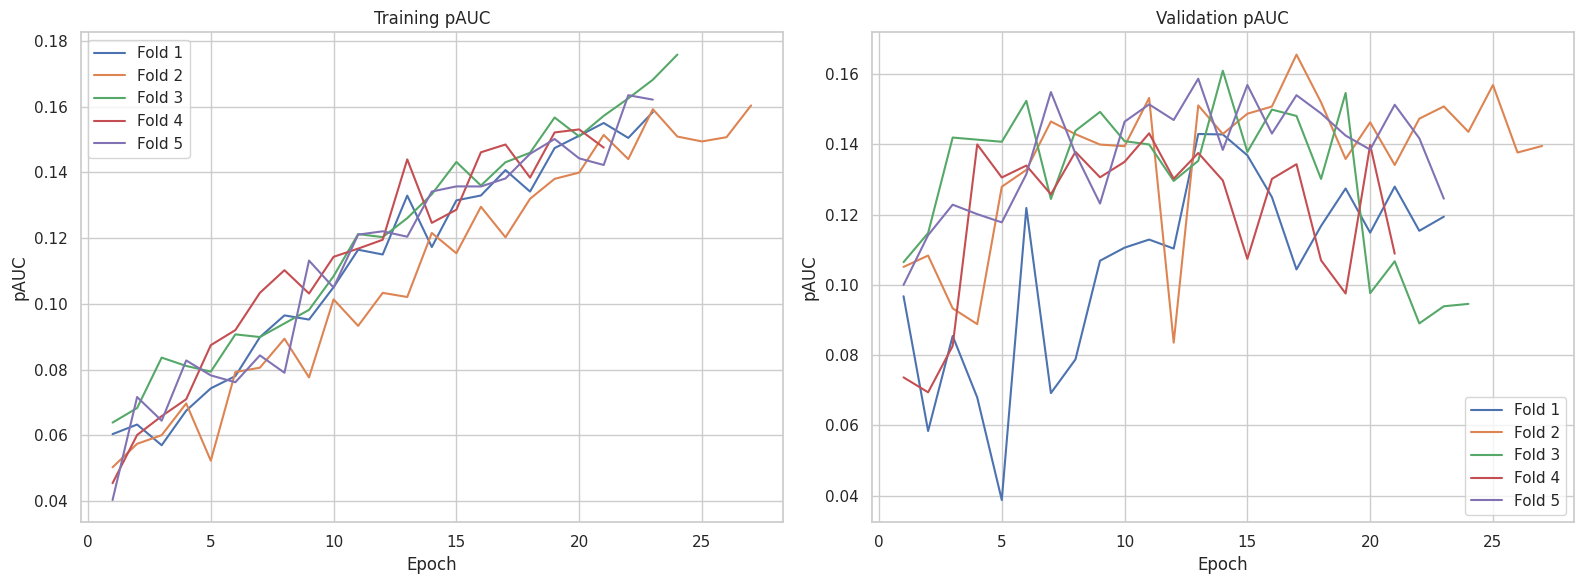

In [15]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_pauc', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training pAUC')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('pAUC')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_pauc', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation pAUC')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('pAUC')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()

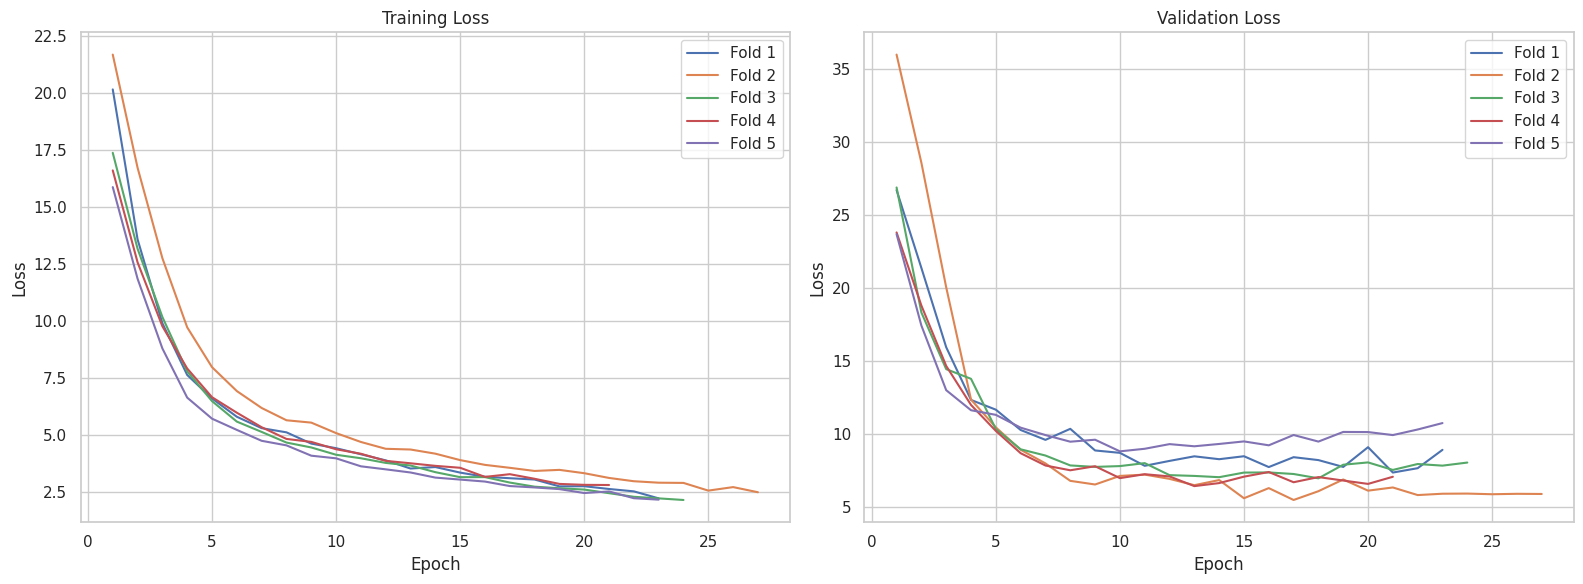

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(x='epoch', y='train_loss', hue='Fold', data=histories, ax=axes[0])
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='best')

sns.lineplot(x='epoch', y='val_loss', hue='Fold', data=histories, ax=axes[1])
axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='best')

fig.tight_layout()
plt.show()